# Train a ConvNet using multiple GPUs

This notebook shows how to train a deep model using multiple GPUs. In this notebook, we use CIFAR-10 dataset and train a VGG-like deep model using 2 GPUs.

First, **please make sure that you are running this notebook with an environment that has at least 2 GPUs**.

Let's import necessary packages:

In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.datasets import get_cifar10

# Dataset preparation

Chainer provides a utility to retrieve and handle the CIFAR-10/100 dataset. In this notebook, we use the dataset class provided by Chainer to use CIFAR-10.

In [2]:
batchsize = 128

train, test = get_cifar10()
train_iter = iterators.MultiprocessIterator(train, batchsize)
test_iter = iterators.MultiprocessIterator(test, batchsize, repeat=False, shuffle=False)

# Model definition

Let's define a deep model.

In [3]:
class VGG(chainer.ChainList):

    def __init__(self, n_class):
        super(VGG, self).__init__(
            ConvBlock(64),
            ConvBlock(64, True),
            ConvBlock(128),
            ConvBlock(128, True),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256, True),
            LinearBlock(),
            LinearBlock(),
            L.Linear(None, n_class)
        )

    def __call__(self, x):
        for f in self.children():
            x = f(x)
        return x
    
class ConvBlock(chainer.Chain):

    def __init__(self, n_ch, pool_drop=False):
        w = chainer.initializers.HeNormal()
        super(ConvBlock, self).__init__()
        with self.init_scope():
            self.conv = L.Convolution2D(None, n_ch, 3, 1, 1, nobias=True, initialW=w)
            self.bn = L.BatchNormalization(n_ch)
        self.pool_drop = pool_drop

    def __call__(self, x):
        h = F.relu(self.bn(self.conv(x)))
        if self.pool_drop:
            h = F.max_pooling_2d(h, 2, 2)
            h = F.dropout(h, ratio=0.25)
        return h

class LinearBlock(chainer.Chain):

    def __init__(self):
        w = chainer.initializers.HeNormal()
        super(LinearBlock, self).__init__()
        with self.init_scope():
            self.fc = L.Linear(None, 1024, initialW=w)

    def __call__(self, x):
        return F.dropout(F.relu(self.fc(x)), ratio=0.5)

Then instantiate the model and setup a optimizer.

In [4]:
model = L.Classifier(VGG(n_class=10))
optimizer = optimizers.Adam()
optimizer.setup(model)

# Create ParallelUpdater

To use multiple GPUs for training, use `ParallelUpdater` instead of `StarndardUpdater` for the updater given to a trainer. So what you need to do is just replacing `StandardUpdater` with `ParallelUpdater`. That's all!

In [5]:
devices = {
    'main': 0,
    'gpu1': 1,
}

updater = training.ParallelUpdater(
    train_iter, optimizer, devices=devices)

trainer = training.Trainer(
    updater, (100, 'epoch'), out='multi_gpu_result')

trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'val/main/loss', 'main/accuracy', 'val/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.Evaluator(test_iter, model, device=devices['main']), name='val')
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))

trainer.run()

epoch       main/loss   val/main/loss  main/accuracy  val/main/accuracy  elapsed_time
1           2.06062     1.72784        0.248561       0.345728           27.6125       
2           1.51435     1.37587        0.431706       0.499407           53.2946       
3           1.22403     1.08813        0.555529       0.636175           78.8932       
4           1.01321     0.991406       0.639666       0.684731           106.35        
5           0.901679    0.875154       0.685582       0.737144           136.299       
6           0.782395    0.828507       0.732292       0.741792           165.523       
7           0.710225    0.84949        0.761949       0.747033           194.874       
8           0.642385    0.633132       0.790144       0.812104           224.745       
9           0.574841    0.63775        0.809303       0.812698           254.329       
10          0.510813    0.638685       0.831562       0.80449            283.289       
11          0.472714    0.576256  

91          0.0263309   0.635631       0.992468       0.889636           2653.49       
92          0.0341086   0.616935       0.990329       0.879648           2682.73       
93          0.0306678   0.775979       0.991648       0.875989           2711.84       
94          0.0269641   0.671159       0.991386       0.885186           2742.81       
95          0.0318551   0.657127       0.990649       0.88212            2771.69       
96          0.0261267   0.649264       0.991546       0.884296           2800.52       
97          0.0299986   0.698202       0.991089       0.886867           2829.12       
98          0.0338298   0.71409        0.990969       0.879351           2858.17       
99          0.0307153   0.65424        0.991587       0.889043           2886.97       
100         0.0284084   0.648113       0.992088       0.885384           2915.83       


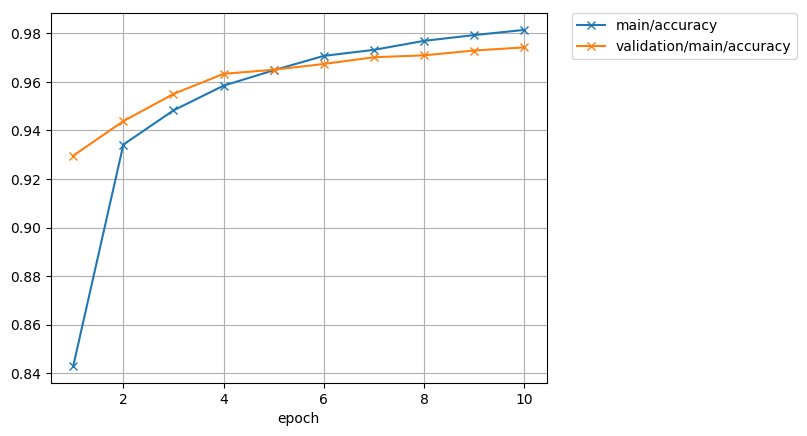

In [6]:
from IPython.display import Image
Image('mnist_result/loss.png')
Image('mnist_result/accuracy.png')

# ChainerCV

[ChainerCV](https://github.com/chainer/chainercv) is a collection of tools to train and run neural networks for computer vision tasks using Chainer. It provides many kinds of models, their pre-trained weights, data augomentation algorithms, dataset abstraction, evaluation tools, etc.

In this notebook, let's use ChainerCV to apply some transformations to the training images for data augmentation.

In [7]:
%%bash
pip install chainercv

Chainer's `TransformDataset` takes two arguments, the first one is a dataset object and the second one is a transformation function. Each datum in the dataset is transformed by using the transformation function. The function should take an input and perform some transformations using any kind of libraries or just array maniputation to the input ndarray, and then return the resulting transformed input.

Let's train the same model with the `TransformDataset` that apply

- Random cropping of (28, 28)-sized sub-region
- Random LR-flipping
- Random color augmentation

using `chainercv.transforms.random_crop`, `chainercv.transforms.random_flip`, and `chainercv.transforms.pca_lighting`, respectively.

In [8]:
from chainercv import transforms

def transform(inputs):
    img, label = inputs
    img = transforms.random_crop(img, (28, 28))
    img = transforms.random_flip(img)
    img = transforms.pca_lighting(img, 0.1)
    return img, label
    
batchsize = 128

train, test = get_cifar10()

train = datasets.TransformDataset(train, transform)

train_iter = iterators.MultiprocessIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

model = L.Classifier(VGG(n_class=10))
optimizer = optimizers.Adam()
optimizer.setup(model)

devices = {
    'main': 0,
    'gpu1': 1,
}
updater = training.ParallelUpdater(
    train_iter, optimizer, devices=devices)

trainer = training.Trainer(
    updater, (100, 'epoch'), out='multi_gpu_result_2')

trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'val/main/loss', 'main/accuracy', 'val/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.Evaluator(test_iter, model, device=devices['main']), name='val')
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))

trainer.run()

epoch       main/loss   val/main/loss  main/accuracy  val/main/accuracy  elapsed_time
1           1.98431     1.57125        0.273497       0.420787           27.4356       
2           1.49766     1.36127        0.446811       0.519778           54.3845       
3           1.22926     1.06972        0.565385       0.645669           83.2746       
4           1.04492     1.01885        0.638107       0.653778           110.789       
5           0.920094    0.890986       0.689738       0.717662           138.658       
6           0.835819    0.95429        0.722035       0.683248           166.987       
7           0.751259    0.736902       0.74976        0.772844           194.712       
8           0.683263    0.723143       0.77496        0.788964           222.172       
9           0.636065    0.643785       0.79176        0.812302           250.009       
10          0.576232    0.594172       0.813619       0.815467           277.722       
11          0.544391    0.547082  

91          0.0514463   0.611787       0.984816       0.887362           2521.67       
92          0.0474498   0.632413       0.985374       0.8929             2549.76       
93          0.0378744   0.709121       0.987572       0.880142           2577.05       
94          0.0438717   0.621942       0.986378       0.889142           2604.65       
95          0.0428542   0.655592       0.987012       0.89735            2632.81       
96          0.0460428   0.54094        0.987179       0.898734           2659.57       
97          0.0507341   0.587891       0.984495       0.893888           2687.69       
98          0.0407599   0.594971       0.987012       0.899624           2715.2        
99          0.0460981   0.658251       0.986418       0.896361           2742.91       
100         0.0444968   0.602549       0.986253       0.898536           2770.95       
